In [6]:
cd C:\\Users\\EthanZhu\\fastai\\old

C:\Users\EthanZhu\fastai\old


In [58]:
!pip -q install flashtorch

In [3]:
from fastai.conv_learner import *
from cv2 import resize
%matplotlib inline

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
class Combine(nn.Module):
    def __init__(self, input_nd, nf=64):
        super(Combine, self).__init__()
        self.output_num = [4, 2, 1]
        
        self.conv1 = nn.Conv2d(input_nd, nf, 4,bias=False)
        
        self.conv2 = nn.Conv2d(nf, nf * 2, 4, bias=False)
        self.BN1 = nn.BatchNorm2d(nf * 2)

        self.conv3 = nn.Conv2d(nf * 2, nf * 4, 4, bias=False)
        self.BN2 = nn.BatchNorm2d(nf * 4)

        self.conv4 = nn.Conv2d(nf * 4, nf * 8, 4, bias=False)
        self.BN3 = nn.BatchNorm2d(nf * 8)

        self.conv5 = nn.Conv2d(nf * 8, 64, 4, bias=False)
        self.fc1 = nn.Linear(10752,2)
        #self.fc2 = nn.Linear(4096, 1000)
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.fc1 = nn.Linear(500‬, 50)
        #self.fc2 = nn.Linear(50, 10)

        #self.rnn = nn.LSTM(
        #    input_size=1000,
        #    hidden_size=64,
        #    num_layers=1,
        #   batch_first=True)
        #self.linear = nn.Linear(64, 2)
        #self.sigmoid = nn.Sigmoid()

    def spatial_pyramid_pool(self, previous_conv, num_sample, previous_conv_size, out_pool_size):
        '''
        previous_conv: a tensor vector of previous convolution layer
        num_sample: an int number of image in the batch
        previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
        out_pool_size: a int vector of expected output size of max pooling layer

        returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
        '''
        # print(previous_conv.size())
        for i in range(len(out_pool_size)):
            # print(previous_conv_size)

            h_wid = int(math.ceil(previous_conv_size[0] // out_pool_size[i]))
            w_wid = int(math.ceil(previous_conv_size[1] // out_pool_size[i]))
            h_pad = (h_wid * out_pool_size[i] - previous_conv_size[0] + 1) // 2
            w_pad = (w_wid * out_pool_size[i] - previous_conv_size[1] + 1) // 2
            maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
            x = maxpool(previous_conv)
            if (i == 0):
                spp = x.view(num_sample, -1)
                # print("spp size:",spp.size())
            else:
                # print("size:",spp.size())
                spp = torch.cat((spp, x.view(num_sample, -1)), 1)
        return spp

    def forward(self, x):

        x = self.conv1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x)
        x = F.leaky_relu(self.BN1(x))

        x = self.conv3(x)
        x = F.leaky_relu(self.BN2(x))
        
        x = self.conv4(x)
        #x = F.leaky_relu(self.BN3(x))
        #x = self.conv5(x)
        #spp = Modified_SPPLayer(4, x)
        spp = self.spatial_pyramid_pool(x, 1, [int(x.size(2)), int(x.size(3))], self.output_num)
        # print(spp.size())
        fc1 = self.fc1(spp)
        #fc2 = self.fc2(fc1)
        s = nn.Sigmoid()
        output = s(fc1)
        
        
        
        
        #LSTM
        #fc1 = fc1.view(-1,1000)
        #r_in = fc1.view(len(fc1),args.batch_size,-1)
        #r_out, _ = self.rnn(r_in)
        #r_out2 = self.linear(r_out[0])
        #r_out2 = self.sigmoid(r_out2)

        return output

In [2]:
class MyDataset(Dataset):
    def __init__(self, txt_path,transform=None,target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        with open(txt_path,'r') as fh:
            next(fh)
            for line in fh:
                imgs.append(line)

        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        fn = self.imgs[index]
        fn = fn.rstrip()
        paths = fn.split(',')
        image_dir_1 = paths[0]
        image_dir_2 = paths[1]
        image_dir_3 = paths[2]
        image_dir_4 = paths[3]
        image_dir_5 = paths[4]
        image_dir_6 = paths[5]
        image_dir_7 = paths[6]
        image_dir_8 = paths[7]
        label = int(paths[8])

        #f_nirs_1 = Image.open(image_dir_1).convert('RGB')
        f_nirs_1 = Image.open(image_dir_1)

        if self.transform is not None:
            f_nirs_1 = self.transform(f_nirs_1)

        #f_nirs_1 = pd.read_csv(image_dir_1)
        #f_nirs_1 = torch.tensor(f_nirs_1.values)
        #f_nirs_1.unsqueeze_(0)

        print(f_nirs_1.size())
        #f_nirs_2 = Image.open(image_dir_2).convert('RGB')
        f_nirs_2 = Image.open(image_dir_2)

        if self.transform is not None:
            f_nirs_2 = self.transform(f_nirs_2)

        #f_nirs_2 = pd.read_csv(image_dir_2)
        #f_nirs_2 = torch.tensor(f_nirs_2.values)
        #f_nirs_2.unsqueeze_(0)
        f_nirs_2 = torch.cat((f_nirs_1,f_nirs_2),0)
        print(f_nirs_2.size())

        #f_nirs_3 = Image.open(image_dir_3).convert('RGB')
        f_nirs_3 = Image.open(image_dir_3)

        if self.transform is not None:
            f_nirs_3 = self.transform(f_nirs_3)
        #f_nirs_3 = pd.read_csv(image_dir_3)
        #f_nirs_3 = torch.tensor(f_nirs_3.values)
        #f_nirs_3.unsqueeze_(0)
        f_nirs_3 = torch.cat((f_nirs_2,f_nirs_3),0)
        print(f_nirs_3.size())

        #f_nirs_4 = Image.open(image_dir_4).convert('RGB')
        f_nirs_4 = Image.open(image_dir_4)

        if self.transform is not None:
            f_nirs_4 = self.transform(f_nirs_4)

        #f_nirs_4 = pd.read_csv(image_dir_4)
        #f_nirs_4 = torch.tensor(f_nirs_4.values)
        #f_nirs_4.unsqueeze_(0)
        f_nirs_4 = torch.cat((f_nirs_3,f_nirs_4),0)
        print(f_nirs_4.size())

        #f_nirs_5 = Image.open(image_dir_5).convert('RGB')
        f_nirs_5 = Image.open(image_dir_5)

        if self.transform is not None:
            f_nirs_5 = self.transform(f_nirs_5)

        #f_nirs_5 = pd.read_csv(image_dir_5)
        #f_nirs_5 = torch.tensor(f_nirs_5.values)
        #f_nirs_5.unsqueeze_(0)
        f_nirs_5 = torch.cat((f_nirs_4,f_nirs_5),0)
        print(f_nirs_5.size())

        #f_nirs_6 = Image.open(image_dir_6).convert('RGB')
        f_nirs_6 = Image.open(image_dir_6)

        if self.transform is not None:
            f_nirs_6 = self.transform(f_nirs_6)

        #f_nirs_6 = pd.read_csv(image_dir_6)
        #f_nirs_6 = torch.tensor(f_nirs_6.values)
        #f_nirs_6.unsqueeze_(0)
        f_nirs_6 = torch.cat((f_nirs_5,f_nirs_6),0)
        print(f_nirs_6.size())

        #f_nirs_7 = Image.open(image_dir_7).convert('RGB')
        f_nirs_7 = Image.open(image_dir_7)

        if self.transform is not None:
            f_nirs_7 = self.transform(f_nirs_7)

        #f_nirs_7 = pd.read_csv(image_dir_7)
        #f_nirs_7 = torch.tensor(f_nirs_7.values)
        #f_nirs_7.unsqueeze_(0)
        f_nirs_7 = torch.cat((f_nirs_6,f_nirs_7),0)
        print(f_nirs_7.size())

        #f_nirs_8 = Image.open(image_dir_8).convert('RGB')
        f_nirs_8 = Image.open(image_dir_8)

        if self.transform is not None:
            f_nirs_8 = self.transform(f_nirs_8)

        #f_nirs_8 = pd.read_csv(image_dir_8)
        #f_nirs_8 = torch.tensor(f_nirs_8.values)
        #f_nirs_8.unsqueeze_(0)
        f_nirs_8 = torch.cat((f_nirs_7,f_nirs_8),0)
        print(f_nirs_8.size())

        return f_nirs_8, label, index

    def __len__(self):
        return len(self.imgs)


In [45]:
img_test = MyDataset(txt_path=r"C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\Visual.csv",transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]), target_transform = None)
print(img_test)
print(img_test[0][0].size())

torch.Size([1, 420, 4480])
torch.Size([2, 420, 4480])
torch.Size([3, 420, 4480])
torch.Size([4, 420, 4480])
torch.Size([5, 420, 4480])
torch.Size([6, 420, 4480])
torch.Size([7, 420, 4480])
torch.Size([8, 420, 4480])
torch.Size([8, 420, 4480])


In [7]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [52]:
class FilterVisualizer():
    def __init__(self, pre_model, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = pre_model.cuda().eval()
        set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img= np.uint8(np.random.uniform(150, 180, (sz, sz, 8)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(self.model, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

In [53]:
layer = 2
filter = 10
p_model = Combine(8)
p_model=torch.load("C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\train5\\model\\Kfold_5_epoch_24.pth")

In [54]:
FV = FilterVisualizer(p_model, size=4, upscaling_steps=12, upscaling_factor=1.2)

In [55]:
FV.visualize(layer, filter, blur=5)

ValueError: operands could not be broadcast together with shapes (4,4,8) (3,) 

In [ ]:

img = PIL.Image.open("layer_"+str(layer)+"_filter_"+str(filter)+".jpg")
plt.figure(figsize=(7,7))
plt.imshow(img)

In [56]:
img= np.uint8(np.random.uniform(1, 1, (56, 56, 8)))/255 

TypeError: Invalid shape (56, 56, 8) for image data

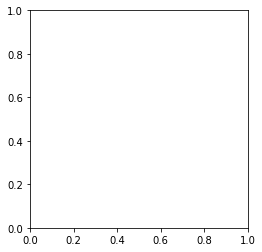

In [57]:
plt.imshow(img)

In [59]:
from flashtorch.utils import apply_transforms, denormalize, format_for_plotting
input_ = apply_transforms(img_test[0][0])

torch.Size([1, 420, 4480])
torch.Size([2, 420, 4480])
torch.Size([3, 420, 4480])
torch.Size([4, 420, 4480])
torch.Size([5, 420, 4480])
torch.Size([6, 420, 4480])
torch.Size([7, 420, 4480])
torch.Size([8, 420, 4480])


In [89]:
f_nirs_1 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_1.png')

In [91]:
f_nirs_1.size

(4480, 420)

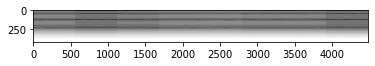

In [69]:
plt.imshow(f_nirs_1,cmap='gray')

In [70]:
f_nirs_2 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_2.png')
f_nirs_3 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_3.png')
f_nirs_4 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_4.png')
f_nirs_5 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_5.png')
f_nirs_6 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_6.png')
f_nirs_7 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_7.png')
f_nirs_8 = Image.open('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_8.png')

In [72]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [93]:
f_nirs_1 = cv2.imread('C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\P18\\e_1\\fnirs\\HHb\\HHb_1.png',0)

In [94]:
f_nirs_1.shape

(420, 4480)

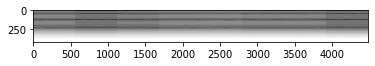

In [95]:
plt.imshow(f_nirs_1,cmap='gray')

In [96]:
f_nirs_1.shape

(420, 4480)

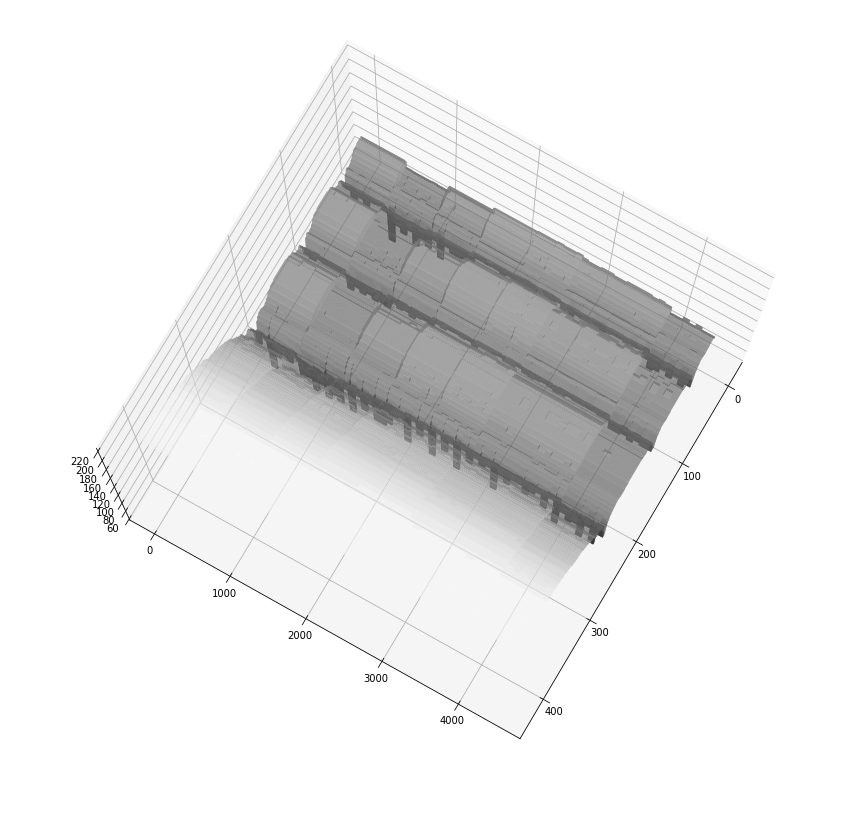

In [98]:
xx, yy = np.mgrid[0:f_nirs_1.shape[0], 0:f_nirs_1.shape[1]]
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, f_nirs_1 ,rstride=1, cstride=1, cmap=plt.cm.gray,linewidth=2)
ax.view_init(80, 30)
plt.show()

In [28]:
def get_features(pretrained_model, x, layers = [1, 3, 5, 7]):  ## get_features 其实很简单

    net1 = nn.Sequential(*list(pretrained_model.children())[:layers[0]])  
#   print net1  
    out1 = net1(x)  

    net2 = nn.Sequential(*list(pretrained_model.children())[layers[0]:layers[1]])  
#   print net2  
    out2 = net2(out1)  

    net3 = nn.Sequential(*list(pretrained_model.children())[layers[1]:layers[2]])  
    out3 = net3(out2)  
    
    net4 = nn.Sequential(*list(pretrained_model.children())[layers[2]:layers[3]])  
    out4 = net4(out3) 
    
    #net5 = nn.Sequential(*list(pretrained_model.children())[layers[3]:layers[4]])  
    #out5 = net5(out4)

    return out1, out2, out3, out4#, out5


In [29]:
class myNet(nn.Module):
    def __init__(self,pretrained_model,layers):
        super(myNet,self).__init__()
        self.net1 = nn.Sequential(*list(pretrained_model.children())[:layers[0]])
        self.net2 = nn.Sequential(*list(pretrained_model.children())[:layers[1]])
        self.net3 = nn.Sequential(*list(pretrained_model.children())[:layers[2]])
        self.net4 = nn.Sequential(*list(pretrained_model.children())[:layers[3]])
        #self.net5 = nn.Sequential(*list(pretrained_model.children())[:layers[4]])

    def forward(self,x):
        out1 = self.net1(x)
        out2 = self.net(out1)
        out3 = self.net(out2)
        out4 = self.net(out3)
        #out5 = self.net(out4)
        return out1,out2,out3,out4#, out5


In [30]:
from torch.autograd import Variable

In [31]:
img_test = MyDataset(txt_path=r"C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\Visual.csv",transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]), target_transform = None)
img_test = img_test[0][0]
img_test = img_test.unsqueeze(0)
img_test = Variable(img_test)

torch.Size([1, 420, 4480])
torch.Size([2, 420, 4480])
torch.Size([3, 420, 4480])
torch.Size([4, 420, 4480])
torch.Size([5, 420, 4480])
torch.Size([6, 420, 4480])
torch.Size([7, 420, 4480])
torch.Size([8, 420, 4480])


In [32]:
p_model = Combine(8)
p_model=torch.load("C:\\Users\\EthanZhu\\Box Sync\\Project\\CNN_LSTM\\Github\\dlfnirs\\FFT_GRAY\\train5\\model\\Kfold_5_epoch_24.pth")

In [33]:
with torch.no_grad():
    img_test = img_test.cuda()
    p_model = p_model.cuda()

In [34]:
torch.cuda.empty_cache()

In [35]:
output1, _ = get_features(p_model,img_test)
print('output1.shape:',output1.shape)
#print('output2.shape:',output2.shape)
#print('output3.shape:',output3.shape)
#print('output4.shape:',output4.shape)
#print('output5.shape:',output5.shape)

RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 4.00 GiB total capacity; 2.59 GiB already allocated; 105.90 MiB free; 13.84 MiB cached)

In [224]:
output1=output1[0].detach().cpu().unsqueeze(dim=1)
output2=output2[0].detach().cpu().unsqueeze(dim=1)
output3=output3[0].detach().cpu().unsqueeze(dim=1)
output4=output4[0].detach().cpu().unsqueeze(dim=1)

In [228]:
output1.size()
output2.size()
output3.size()
output4.size()

torch.Size([256, 1, 208, 2238])

In [229]:
output2.size()

torch.Size([128, 1, 209, 2239])

In [238]:
from torch.utils.tensorboard import SummaryWriter
tb_logger = SummaryWriter()

In [239]:
from torchvision.utils import make_grid
tb_logger.add_image('layer1', make_grid(output1, nrow=1, normalize=False),1)
tb_logger.add_image('layer2', make_grid(output2, nrow=1, normalize=False),1)
tb_logger.add_image('layer3', make_grid(output3, nrow=1, normalize=False),1)
tb_logger.add_image('layer4', make_grid(output4, nrow=1, normalize=False),1)

In [32]:
%tensorboard --logdir=runs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13544.

In [30]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
%reload_ext tensorboard

In [29]:
del /q %TMP%\.tensorboard-info\*

UsageError: Line magic function `%taskkill` not found.
